In [1]:
# pip install pandas matplotlib
import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt

# ---------- 0) Paths ----------
# Edit these if your files are elsewhere:
p_23 = Path("23andme_v5_hg19_ref.txt.gz")
p_ann = Path("var_drug_ann.tsv")

In [4]:
# ---------- 1) Load 23andMe file ----------
p_23 = "23andme_v5_hg19_ref.txt"  # or the full path if needed

df_23 = pd.read_csv(
    p_23,
    sep="\t",
    header=0,        # first line has headers
    names=["CHR", "POS", "dbSNP_ID", "ALLELE"],  # enforce the correct order
    dtype=str,
)

# Drop rows missing rsIDs (some entries have i###### codes)
df_23 = df_23[df_23["dbSNP_ID"].str.startswith("rs", na=False)].copy()

# Rename to match project convention
df_23.rename(columns={"ALLELE": "ALLELE_23andme"}, inplace=True)

print(df_23.head())
print(df_23.shape)


    CHR     POS     dbSNP_ID ALLELE_23andme
0  chr1   74792   rs13328684              G
1  chr1  565508    rs9283150              G
3  chr1  727841  rs116587930              G
4  chr1  752721    rs3131972              A
5  chr1  754105   rs12184325              C
(620633, 4)


In [5]:
# ---------- 2) Load PharmGKB variant annotation file ----------
p_ann = "var_drug_ann.tsv"

# Skip the single bad line containing “The 15-year cumulative”
lines_clean = []
with open(p_ann, "r", encoding="utf-8", errors="replace") as f:
    for line in f:
        if "The 15-year cumulative" in line:
            continue
        lines_clean.append(line)

from io import StringIO
df_ann = pd.read_csv(StringIO("".join(lines_clean)), sep="\t", dtype=str, low_memory=False)

# ---------- 3) Select & rename relevant columns ----------
col_map = {
    "Variant/Haplotypes": "dbSNP_ID",
    "Gene": "GENE_SYMBOL",
    "Drug(s)": "DRUG_NAME",
    "PMID": "PMID",
    "Phenotype Category": "PHENOTYPE_CATEGORY",
    "Significance": "SIGNIFICANCE",
    "Notes": "NOTES",
    "Sentence": "SENTENCE",
    "Alleles": "ALLELE_PharmGKB",
}

df_ann = df_ann[list(col_map.keys())].rename(columns=col_map)

# Keep only rows with valid rsIDs
df_ann = df_ann[df_ann["dbSNP_ID"].str.fullmatch(r"rs\d+", na=False)].copy()

print("PharmGKB loaded:", df_ann.shape)
print(df_ann.head())

PharmGKB loaded: (9817, 9)
     dbSNP_ID GENE_SYMBOL                                          DRUG_NAME  \
1   rs2909451        DPP4                                        sitagliptin   
2    rs706795       FAIM2  citalopram, escitalopram, fluoxetine, fluvoxam...   
3  rs16918842       OPRK1                                             heroin   
5   rs2285676      KCNJ11                                        sitagliptin   
7    rs163184       KCNQ1                                        sitagliptin   

       PMID PHENOTYPE_CATEGORY SIGNIFICANCE  \
1  39792745           Efficacy          yes   
2  40054571           Efficacy           no   
3  31940240             Dosage           no   
5  39792745           Efficacy          yes   
7  39792745           Efficacy          yes   

                                               NOTES  \
1  "Patients with the rs2909451 TT genotype in th...   
2  "We observed nominally significant association...   
3  No significant difference in allele or

In [6]:
# ---------- 4) Merge with 23andMe ----------
df_merge = df_ann.merge(df_23[["dbSNP_ID", "ALLELE_23andme"]], on="dbSNP_ID", how="inner")

df_merge = df_merge[
    ["dbSNP_ID", "GENE_SYMBOL", "DRUG_NAME", "PMID",
     "PHENOTYPE_CATEGORY", "SIGNIFICANCE", "NOTES", "SENTENCE",
     "ALLELE_PharmGKB", "ALLELE_23andme"]
]
print("Merged rows:", df_merge.shape)
df_merge.head()

Merged rows: (6111, 10)


,dbSNP_ID,GENE_SYMBOL,DRUG_NAME,PMID,PHENOTYPE_CATEGORY,SIGNIFICANCE,NOTES,SENTENCE,ALLELE_PharmGKB,ALLELE_23andme
0,rs706795,FAIM2,"citalopram, escitalopram, fluoxetine, fluvoxam...",40054571,Efficacy,no,"""We observed nominally significant association...",Allele T is associated with increased response...,T,T
1,rs16918842,OPRK1,heroin,31940240,Dosage,no,No significant difference in allele or genotyp...,Allele T is not associated with dose of heroin...,T,C
2,rs163184,KCNQ1,sitagliptin,39792745,Efficacy,yes,"""KCNQ1 gene polymorphisms also significantly a...",Genotype GG is associated with decreased respo...,GG,T
3,rs7754840,CDKAL1,sitagliptin,39792745,Efficacy,no,"""Patients with the rs7754840 CG genotype showe...",Genotype CG is associated with increased respo...,CG,G
4,rs1799853,CYP2C9,sitagliptin,39792745,Efficacy,yes,"""CYP2C9 gene polymorphisms also significantly ...",Genotype TT is associated with decreased respo...,TT,C


In [7]:
# ---------- 5) Filter for significant efficacy variants ----------
df_sig_eff = df_merge[
    (df_merge["SIGNIFICANCE"].str.lower() == "yes") &
    (df_merge["PHENOTYPE_CATEGORY"].str.lower() == "efficacy")
].copy()

print("Filtered (significant + efficacy):", df_sig_eff.shape)
df_sig_eff.head()

Filtered (significant + efficacy): (1434, 10)


,dbSNP_ID,GENE_SYMBOL,DRUG_NAME,PMID,PHENOTYPE_CATEGORY,SIGNIFICANCE,NOTES,SENTENCE,ALLELE_PharmGKB,ALLELE_23andme
2,rs163184,KCNQ1,sitagliptin,39792745,Efficacy,yes,"""KCNQ1 gene polymorphisms also significantly a...",Genotype GG is associated with decreased respo...,GG,T
4,rs1799853,CYP2C9,sitagliptin,39792745,Efficacy,yes,"""CYP2C9 gene polymorphisms also significantly ...",Genotype TT is associated with decreased respo...,TT,C
5,rs7903146,TCF7L2,exenatide,30700996,Efficacy,yes,"""After treatment with exenatide, only CT/TT in...",Genotypes CT + TT is associated with increased...,CT + TT,C
8,rs8099917,IFNL3,"peginterferon alfa-2a, peginterferon alfa-2b, ...",26075078,Efficacy,yes,A multivariate logistic model showed that the ...,Genotype TT is associated with increased respo...,TT,T
9,rs8099917,IFNL3,"peginterferon alfa-2b, ribavirin",22328925,Efficacy,yes,This genotype is associated with sustained vir...,Genotype TT is associated with increased respo...,TT,T


In [8]:
# ---------- 6) Save 23andme_PharmGKB_map.tsv ----------
cols_map = [
    "dbSNP_ID", "GENE_SYMBOL", "DRUG_NAME",
    "NOTES", "SENTENCE", "ALLELE_PharmGKB", "ALLELE_23andme"
]
df_sig_eff[cols_map].to_csv("23andme_PharmGKB_map.tsv", sep="\t", index=False)
print(" Saved 23andme_PharmGKB_map.tsv")

 Saved 23andme_PharmGKB_map.tsv


In [9]:
# ---------- 7) Summarized file ----------
# GENE_SYMBOL, DRUG_NAME, dbSNP_IDs (semicolon-separated)
summary = (
    df_sig_eff.groupby(["GENE_SYMBOL", "DRUG_NAME"])["dbSNP_ID"]
    .apply(lambda s: ";".join(sorted(set(s))))
    .reset_index(name="dbSNP_IDs")
)
summary.to_csv("23andme_PharmGKB_summary.tsv", sep="\t", index=False)
print("Saved 23andme_PharmGKB_summary.tsv")

Saved 23andme_PharmGKB_summary.tsv


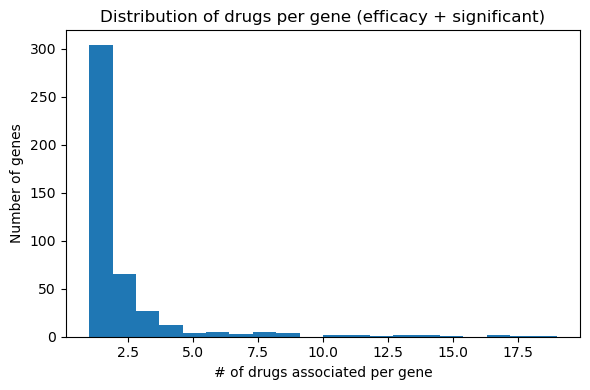

In [10]:
# ---------- 8) Plot histograms ----------
# Number of drugs per gene
drugs_per_gene = df_sig_eff.groupby("GENE_SYMBOL")["DRUG_NAME"].nunique()
plt.figure(figsize=(6,4))
plt.hist(drugs_per_gene, bins=20)
plt.xlabel("# of drugs associated per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of drugs per gene (efficacy + significant)")
plt.tight_layout()
plt.show()

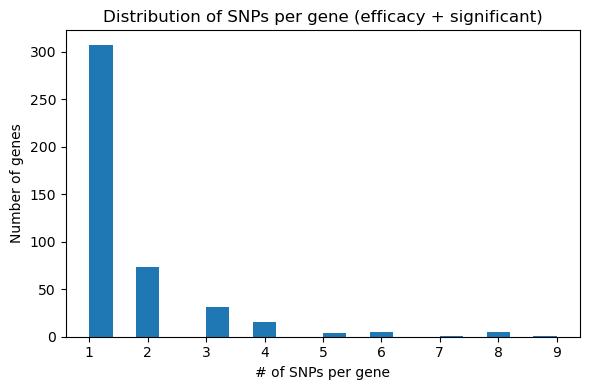

In [11]:
# Number of SNPs per gene
snps_per_gene = df_sig_eff.groupby("GENE_SYMBOL")["dbSNP_ID"].nunique()
plt.figure(figsize=(6,4))
plt.hist(snps_per_gene, bins=20)
plt.xlabel("# of SNPs per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of SNPs per gene (efficacy + significant)")
plt.tight_layout()
plt.show()